# DES431 Project: Recommendation System

# Background

**MovieLens** is a movie recommendation system operated by GroupLens, a research group at the University of Minnesota. MovieLens has been developed to provide personalized movie recommendations to its users based on their viewing history and preferences.

# Tasks

1. This project is to be completed by a group of up to three students.
2. Propose and implement your own recommendation system based on the MovieLens dataset.
   - Use `ratings_train.csv` as the training set and `ratings_valid.csv` as the validation set.
   - Your recommendation system may utilize information from `movies.csv` for making recommendations.
   - The structure of the data files is detailed at `https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html`.
   - The goal of the recommendation system is to minimize the root-mean-square error (RMSE), i.e., to minimize the difference between the predicted and actual ratings.
   - You are required to modify the provided program to enhance recommendation quality. Submitting the original, unaltered program will be considered plagiarism.
3. Prepare slides for a 7-minute presentation that explains your proposed technique and algorithm for making recommendations, and demonstrates your RMSE results on the validation set. The slides must include
   - A diagram and detailed explanation of your model
   - Results on the validation set
   - A discussion of the pros and cons of your model
4. Submit your Python notebook and the presentation slides in PDF format via Google Classroom by May 5, 2025, at 23:59.
   - All members of the group must individually submit their work to Google Classroom.
   - Late submissions will not be accepted and will incur a 10% deduction.
   - Do not procrastinate. Plagiarism and code duplication will be rigorously checked.
5. Present your work on either May 7 or May 14, within a 7-minute timeframe. Presentations exceeding 7 minutes will result in point deductions. The presentation schedule will be announced later.
6. Attend the presentation physically on-site in the classroom on both days. Late penalty will be applied.
7. Evaluate the presenations of all groups including your group.

You need to complete all tasks (1--7). Failure to complete any task will result in a score deduction.


In [6]:
# Edit this cell for the group name and members
# Group name: ben10
# Group member1: Kanapitch (6522790276)
# Group member2: Witchapas (6522780780)
# Group member3: Kueakul (6522772464)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
import itertools

# Loading and preprocess data

In [8]:
train = pd.read_csv('ratings_train.csv')
valid = pd.read_csv('ratings_valid.csv')
movies= pd.read_csv('movies.csv')

all_users = np.union1d(train.userId.unique(), valid.userId.unique())
all_items = np.union1d(train.movieId.unique(), valid.movieId.unique())
user2idx  = {u:i for i,u in enumerate(all_users)}
item2idx  = {m:i for i,m in enumerate(all_items)}

train_u = train.userId.map(user2idx).values
train_i = train.movieId.map(item2idx).values
train_r = train.rating.values
valid_u = valid.userId.map(user2idx).values
valid_i = valid.movieId.map(item2idx).values
valid_r = valid.rating.values

n_users, n_items = len(all_users), len(all_items)

# Latent Factor Model + Biases (Bias MF)

In [9]:
def train_bias_mf(u_train, i_train, r_train,
                  u_val,   i_val,   r_val,
                  n_users, n_items,
                  k, alpha, lam, epochs):
    mu  = r_train.mean()
    b_u = np.zeros(n_users)
    b_i = np.zeros(n_items)
    P   = np.random.normal(0, .1, (n_users, k))
    Q   = np.random.normal(0, .1, (n_items, k))
    history = []

    for _ in range(epochs):
        for u,i,r in zip(u_train, i_train, r_train):
            pred = mu + b_u[u] + b_i[i] + P[u].dot(Q[i]) # Latent FM + Biases
            e    = r - pred
            b_u[u] += alpha*(e - lam*b_u[u])
            b_i[i] += alpha*(e - lam*b_i[i])
            P[u]   += alpha*(e*Q[i]   - lam*P[u])
            Q[i]   += alpha*(e*P[u]   - lam*Q[i])

        preds = (mu
                 + b_u[u_val]
                 + b_i[i_val]
                 + np.sum(P[u_val]*Q[i_val], axis=1))
        history.append(sqrt(np.mean((r_val - preds)**2)))

    return (mu, b_u, b_i, P, Q), history

# Hyperparameter grid-search (10 epochs)

---



In [10]:
param_grid = {
    'k':     [10, 20, 50],
    'alpha': [0.002, 0.005, 0.01],
    'lam':   [0.01, 0.02, 0.05]
}

results = []
for k_, α_, λ_ in itertools.product(param_grid['k'],
                                   param_grid['alpha'],
                                   param_grid['lam']):
    _, hist = train_bias_mf(
        train_u, train_i, train_r,
        valid_u, valid_i, valid_r,
        n_users, n_items,
        k_, α_, λ_, epochs=10
    )
    results.append({'k':k_, 'alpha':α_, 'lam':λ_, 'rmse':hist[-1]})

df = pd.DataFrame(results).sort_values('rmse').reset_index(drop=True)
best = df.iloc[0]
best_k, best_alpha, best_lam = int(best.k), best.alpha, best.lam
print("Top 3 hyperparams:\n", df.head(3))

Top 3 hyperparams:
     k  alpha   lam      rmse
0  10  0.005  0.05  0.892593
1  50  0.005  0.05  0.893097
2  20  0.005  0.02  0.893277


# Retrain best MF model for 100 epochs and plot RMSE curve

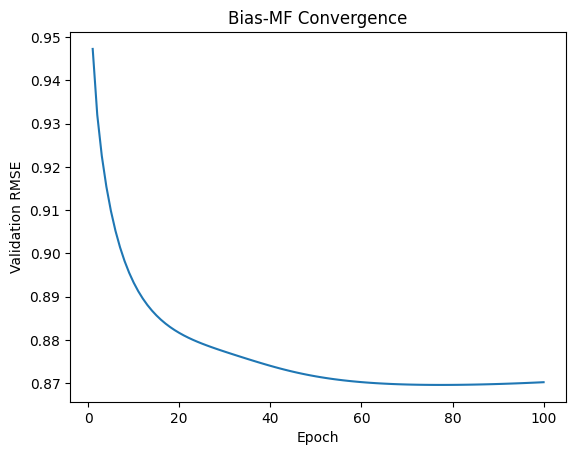

In [11]:
(params, history) = train_bias_mf(
    train_u, train_i, train_r,
    valid_u, valid_i, valid_r,
    n_users, n_items,
    best_k, best_alpha, best_lam,
    epochs=100
)
mu, b_u, b_i, P, Q = params

plt.plot(range(1,101), history)
plt.xlabel('Epoch'); plt.ylabel('Validation RMSE')
plt.title('Bias-MF Convergence')
plt.show()

# Item-based CF predictor

In [12]:
R = coo_matrix((train_r, (train_u, train_i)), shape=(n_users, n_items))
item_sim = cosine_similarity(R.T.tocsr(), dense_output=False)

def predict_ibcf(u, i, k=20):
    idx = np.where(train_u==u)[0]
    if len(idx)==0: return mu
    items = train_i[idx]
    sims  = item_sim[i, items].toarray().ravel()
    top   = np.argsort(sims)[-k:]
    w, r  = sims[top], train_r[idx][top]
    return np.dot(w, r)/(w.sum()+1e-8)

preds_ibcf = np.array([predict_ibcf(u,i) for u,i in zip(valid_u, valid_i)])

# Compute MF predictions

In [13]:
preds_mf = (
    mu
    + b_u[valid_u]
    + b_i[valid_i]
    + np.sum(P[valid_u]*Q[valid_i], axis=1)
)

# Ensemble (MF + IBCF)

In [14]:
best_rmse, best_w = float('inf'), None
for w in np.linspace(0,1,11):
    ens = w*preds_mf + (1-w)*preds_ibcf
    rmse = sqrt(np.mean((valid_r-ens)**2))
    if rmse < best_rmse:
        best_rmse, best_w = rmse, w

print(f'Ensemble RMSE={best_rmse:.4f} at w_MF={best_w:.1f}')

Ensemble RMSE=0.8108 at w_MF=0.4


In [15]:
# Baseline: predict every rating = global mean
mu0 = train_r.mean()
rmse_baseline = sqrt(((valid_r - mu0)**2).mean())

# MF alone
rmse_mf = sqrt(((valid_r - preds_mf)**2).mean())

# Item-CF alone
rmse_cf = sqrt(((valid_r - preds_ibcf)**2).mean())

# Ensemble (best_rmse)
rmse_ens = best_rmse

print(f"Baseline RMSE  = {rmse_baseline:.4f}")
print(f"Bias-MF RMSE   = {rmse_mf:.4f}")
print(f"Item-CF RMSE   = {rmse_cf:.4f}")
print(f"Ensemble RMSE  = {rmse_ens:.4f}")

Baseline RMSE  = 1.0070
Bias-MF RMSE   = 0.8702
Item-CF RMSE   = 0.8388
Ensemble RMSE  = 0.8108


In [16]:
results_df = pd.DataFrame({
    "Model": [
        "Baseline (global mean)",
        f"Bias-MF (k={best_k}, α={best_alpha}, λ={best_lam})",
        "Item-CF (k=20)",
        f"Ensemble (w_MF={best_w:.1f})"
    ],
    "Validation RMSE": [
        rmse_baseline,
        rmse_mf,
        rmse_cf,
        rmse_ens
    ]
})
results_df

,Model,Validation RMSE
0,Baseline (global mean),1.007043
1,"Bias-MF (k=10, α=0.005, λ=0.05)",0.870203
2,Item-CF (k=20),0.838802
3,Ensemble (w_MF=0.4),0.810839
